In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autotime
%timeit

In [3]:
import json_lines
import pandas as pd
import numpy as np
## Cell computation timer
import jenkspy
from functools import reduce
import os, json
import pandas as pd
import numpy as np
import pandas as pd
import json
from speed_functions1 import * # -- seperate .py file 


# || 2. Declare test data locations

json_files=[]

Data_Loc = r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\Second Spectrum meta'
#filename = r'C:\Users\Home\Documents\Second Spectrum Everton Project\southampton_metadata/'+str(file)+'.json'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".json")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        json_files.append(filename)
        
    
json_files=json_files[4:5]
json_files

['2124179']

time: 3.96 ms


In [4]:
#### subset data for GK's ####
All_GKs=pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\All_GKs.csv')
GK_list=list(All_GKs.id.unique())

A=[]
B=[]
C=[]

for file in json_files:
    
    # reading the JSON-lines insights data in from folder
    filename= r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\Second Spectrum Insight/'+str(file)+'.jsonl'

    with open(filename) as f:
        lines = f.read().splitlines()


    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_inter['json_element'].apply(json.loads)

    df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
    df_final.columns = df_final.columns.str.replace(r'2sMarking.', '')
    df_final.columns = df_final.columns.str.replace(r'optaEvent.', 'opta_')
    df_final['frameIdx']=df_final['frameIdx'].fillna(-1).astype(int)
        
    df_final=pd.merge(df_final,All_GKs,left_on='opta_id',right_on='id',how='left')
    
    #del df_final['sequence']
    
    df_frames=df_final[df_final['opta_id'].isin(GK_list)].reset_index(drop=True)

    frameIds_TO_list=list(set(df_frames.frameIdx))
    frameIds_TO_list.sort()

    Gk_sequence_id = 0
    gap_threshold=200
    Gk_sequence_id_list = [0]

    for GoalKick in range(1,len(frameIds_TO_list)):

            if (frameIds_TO_list[GoalKick] - frameIds_TO_list[GoalKick-1])<= gap_threshold:

                Gk_sequence_id_list.append(Gk_sequence_id)

            else:
                Gk_sequence_id = Gk_sequence_id + 1
                Gk_sequence_id_list.append(Gk_sequence_id)


    Gk_sequence_info = pd.DataFrame(
        {'frameIdx': frameIds_TO_list,
         'Gk_sequence_id': Gk_sequence_id_list
        })

    Gk_sequence_info.sort_values(by='frameIdx',ascending=True)


    start_of_seq = []
    end_of_seq = [] 

    unique_sequenceids = list(set(Gk_sequence_id_list))

    for uID in unique_sequenceids:

        temp = Gk_sequence_info[Gk_sequence_info['Gk_sequence_id'] == uID]

        start_of_seq.append(min(temp.frameIdx))
        end_of_seq.append(min(temp.frameIdx)+1000)

    GK_sequence_summary = pd.DataFrame(
        {'frameID_start': start_of_seq,
         'frameID_end': end_of_seq,
         'Gk_sequence_id': unique_sequenceids
        })

    ####### Unzip the frames #######
    GK_sequence_summary['match_id']=str(file)
    GK_sequence_summary['sequence']=GK_sequence_summary['Gk_sequence_id'].astype(str)+ "-"+str(file)
    

    zipped = zip(GK_sequence_summary['Gk_sequence_id'],GK_sequence_summary['frameID_start'], GK_sequence_summary['frameID_end'])
    
    dff = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['GK_sequence_id','frameIdx'])
    GK_sequence_summary_frames=dff['frameIdx'].to_list()
    GK_sequence_summary=pd.merge(GK_sequence_summary,df_final,left_on='frameID_start',right_on='frameIdx',how='left')

    ##### Merging the tracking dataset ####
    
    filename= r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\Second Spectrum JSONL/'+str(file)+'.jsonl'


    period=[]
    frameIdx=[]
    gameClock=[]
    wallClock=[]
    homePlayers=[]
    awayPlayers=[]
    ball=[]
    live=[]
    lastTouch=[]



    with open(filename, 'rb') as f:


    # opening file in binary(rb) mode    
        for item in json_lines.reader(f):
            period.append(item["period"])
            frameIdx.append(item["frameIdx"])
            gameClock.append(item["gameClock"])
            wallClock.append(item["wallClock"])
            homePlayers.append(item["homePlayers"])
            awayPlayers.append(item["awayPlayers"])
            ball.append(item["ball"])
            live.append(item["live"])
            lastTouch.append(item["lastTouch"])

    df = pd.DataFrame(
        {'period': period,
         'frameIdx': frameIdx,
         'gameClock': gameClock,
         'wallClock': wallClock,
         'homePlayers': homePlayers,
         'awayPlayers': awayPlayers,
         'ball': ball,
         'lastTouch': lastTouch,
         'live': live
        })
    df.reset_index(level=0, inplace=True)

    l = df['homePlayers'].str.len()
    n = df['awayPlayers'].str.len()
    df1 = pd.DataFrame(np.concatenate(df['homePlayers']).tolist(), index=np.repeat(df.index, l))
    df1['xyz']=df1['xyz'].fillna('')
    df1[['x','y','z']] = pd.DataFrame(df1.xyz.tolist(), index= df1.index)
    df1=df1.drop('xyz',1)
    df1['team']='1'
    df2 = pd.DataFrame(np.concatenate(df['awayPlayers']).tolist(), index=np.repeat(df.index, n))
    df2['xyz']=df2['xyz'].fillna('')
    df2[['x','y','z']] = pd.DataFrame(df2.xyz.tolist(), index= df2.index)
    df2=df2.drop('xyz',1)
    df2['team']='-1'
    df3=df['ball'].apply(pd.Series)
    df3[['x','y','z']] = df3['xyz'].apply(pd.Series)
    df3['playerId']='00000'
    df3['number']='00'
    df3['team']='0'
    df3=df3.drop('xyz',1)
    df3.reset_index(level=0, inplace=True)
    df2.reset_index(level=0, inplace=True)
    df1.reset_index(level=0, inplace=True)
    df_join=pd.concat([df1, df2,df3], ignore_index=True, sort=True)
    df_join=df_join.sort_values(['index', 'team'], ascending=[True, True]).reset_index(drop=True)
    result = pd.merge(df, df_join, on='index', how='left').drop(['homePlayers', 'awayPlayers', 'ball'], axis=1).reset_index(drop=True)
      
    
    ### subsetting data only for GK's ###
    result=result[(result['frameIdx'].isin(GK_sequence_summary_frames))& (result['x']!=0)].reset_index(drop=True)
    
    #### Converting the (x,y) coordinates from (-60,0,60) to (0,60,120) ####
    
    result=pd.merge(result,dff,on='frameIdx',how='left')
    result['sequence']=result['GK_sequence_id'].astype(str)+ "-"+str(file)
    
    
    #### Checking the GK's starting position in a Goal Kick ####
    cols=['frameIdx','x','GK_sequence_id','playerId']
    check1=result[result['playerId'] == '00000'][cols]
    check=pd.DataFrame(check1.groupby(['GK_sequence_id','frameIdx','playerId'])['x'].mean())
    check=check.reset_index(level=['GK_sequence_id', 'frameIdx','playerId']).drop_duplicates(subset=['GK_sequence_id'],keep='first', inplace=False)
    check['side']=np.where(check['x']<=0,'Left','Right')

    result=pd.merge(result,check[['frameIdx','side','playerId']],on=['frameIdx','playerId'],how='left')
    
    result=result.sort_values(['frameIdx','playerId'], ascending=[True,True])
    result['side']=result['side'].fillna(method='ffill')
    
    result['x']= np.where(result['side']=='Right',result['x']*-1,result['x'])
    result['y']= np.where(result['side']=='Right',result['y']*-1,result['y'])

    #### Adjusting the coordinates
    result['x1']=result['x']+52.5
    result['y1']=result['y']+34.5

    result['x1']=np.where(result['x1']<0,0,result['x1'])
    result['y1']=np.where(result['y1']<0,0,result['y1'])

    
    ##########################################################################################
    ############### The below functions add relative distance to ball, goals ################
    ##########################################################################################

    def add_ball_xy(result2):

        ball_df = result2[result2['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1','z']]
        ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1','ball_z']

        result2 = result2.merge(ball_df, on = "frameIdx")

        return(result2)


    def add_distance_to_ball(result2):

        if 'ball_x1' in result2.columns:
            result2['distance_to_ball'] = result2[['x1', 'y1']].sub(np.array( result2[['ball_x1', 'ball_y1']] )).pow(2).sum(1).pow(0.5)
            result2.distance_to_ball = result2.distance_to_ball.round(2)
            return(result2)

        else:
            print("x||----------------")
            print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
            print("Use 'add_ball_xy' to add the missing coordinates")
            print("----------------||x")

    def add_distance_to_goals(result2, x = 60):

        result2['distance_to_goal1'] = result2[['x', 'y']].sub(np.array( [-x, 0] )).pow(2).sum(1).pow(0.5)
        result2['distance_to_goal2'] = result2[['x', 'y']].sub(np.array( [x, 0] )).pow(2).sum(1).pow(0.5)

        # result2data.distance_to_goal1 = result2data.distance_to_goal1.round(2)
        # result2data.distance_to_goal2 = result2data.distance_to_goal2.round(2)

        return(result2)

    result=add_ball_xy(result)
    result = add_speed_classification(result)
    result=add_distance_to_ball(result)
    result=add_distance_to_goals(result)
    result=result.sort_values(['frameIdx','playerId'], ascending=[True,True]).drop_duplicates(keep='first', inplace=False)
    result['match_id']=str(file)
       
    #### Merging the team data sets

    Player= pd.read_excel(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\All_possessions.xlsx')
    Player['Full_Player_Name']=Player['First']+" "+Player['Last']
    Player['playerId']=Player['uID'].astype(str).str[1:]
    Player['match_id']=Player['SoccerDocument_uID'].astype(str).str[1:]
    Player['Team_Name']=Player['Name'].astype(str)
    Player=Player[['Team_Name','Full_Player_Name','playerId','match_id']]
    result1=pd.merge(result,Player,on=['match_id','playerId'],how='left')

    # reading the JSON metadata in from folder
    filename = r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\Second Spectrum meta/'+str(file)+'.json'
    with open(filename) as train_file:
        dict_train = json.load(train_file)

    # converting json dataset from dictionary to dataframe
    df = (pd.DataFrame.from_dict(dict_train, orient='index')).T

    l = df['homePlayers'].str.len()
    n = df['awayPlayers'].str.len()
    df1 = pd.DataFrame(np.concatenate(df['homePlayers']).tolist(), index=np.repeat(df.index, l))
    df2 = pd.DataFrame(np.concatenate(df['awayPlayers']).tolist(), index=np.repeat(df.index, n))
    k = df['periods'].str.len()
    df3 = pd.DataFrame(np.concatenate(df['periods']).tolist(), index=np.repeat(df.index, k))
    df1=df1[['name', 'position', 'optaId']].reset_index(drop=True)
    df2=df2[['name', 'position', 'optaId']].reset_index(drop=True)
    # Change the column names 
    df1.columns =['name', 'position', 'playerId'] 
    df2.columns =['name', 'position', 'playerId'] 
    df_join=pd.concat([df1, df2], ignore_index=True, sort=True)
    df_join['match_id']=df['optaId']
    df_join['match_id']=df_join['match_id'].fillna(method='ffill')
    result1 = pd.merge(result1, df_join, on=['match_id','playerId'], how='left')
    result1.name=result1.name.fillna('Ball')
    result1.Team_Name=result1.Team_Name.fillna('Ball')
    result1.position=result1.position.fillna('Ball')
    result1.match_id=result1.match_id.fillna(method='ffill')
       
    #df_final=df_final.iloc[:,:-19]
    result2 = pd.merge(result1, df_final, on=['frameIdx'],how='left')
    result2.sort_values(['sequence','frameIdx','distance_to_ball'], ascending=[True,True,True]).reset_index(drop=True)
    result2['Ball_Possession']=result2['Ball_Possession'].fillna(method='ffill')
    result2['Final_check']=result2['Final_check'].fillna(method='ffill')
    result2['Name']=result2['Name'].fillna(method='ffill')
    result2['Possession_Result']=np.where((result2['Name']==result2['Team_Name']),'In_Possession','Out_Possession')
    result2['Possession_Result']=result2['Possession_Result'].fillna(method='ffill')
    
    ## Implementing clusters to cluster defense of opposition
    sequence_summary_frames=list(result2.sequence.unique())


    b=[]
    a=[]
    e=[]
    f=[]
    g=[]
    k=[]
    l=[]
    z=[]
    j=[]
    x=[]
    p=[]

    for frame in sequence_summary_frames:

        track_seg = result2[result2['sequence'] == frame].reset_index(drop=True)
        gk_sequence_summary_frames=list(track_seg.frameIdx.unique())
        gk_sequence_summary_frames1=gk_sequence_summary_frames[0]

        ### Choosing frames for the only the first 4 seconds ###
        gk_sequence_summary_framesx=gk_sequence_summary_frames[0:100]
        gk_sequence_summary_frames2=gk_sequence_summary_framesx[::12]
        track_seg=track_seg.sort_values(['frameIdx'], ascending=[True])
        track_seg1=track_seg[track_seg['frameIdx']==gk_sequence_summary_frames1].reset_index(drop=True)
        frame_select=track_seg1.frameIdx.unique()
        frame_select=frame_select[0]
        sequence_id=track_seg1.sequence.unique()
        Ball_Possession=track_seg1.Ball_Possession.unique()
        Final_check=track_seg1.Final_check.unique()
        Time=track_seg1.sec_diff.unique()

        track_seg1=track_seg1[(track_seg1['Team_Name']!=track_seg1['Name']) & (track_seg1['Team_Name'] != 'Ball')
                             & (track_seg1['position'] != 'GK')].reset_index()

        breaks = jenkspy.jenks_breaks(track_seg1['x1'], nb_class=3)

        track_seg1['Block']=pd.cut(track_seg1['x1'],
                                  bins=breaks,
                                 labels=['First_Line','Second_Line','Third_Line'],
                                 include_lowest=True)

        OOP=track_seg1.Team_Name.unique()



        track_seg1=track_seg1[['Possession_Result','Team_Name','Block','sequence','playerId_x',
                              'Name','speed_class','number','speed']]
        First_line=track_seg1[track_seg1['Block']=='First_Line'][['playerId_x']].reset_index(drop=True)
        First_line=list(First_line['playerId_x'].unique())
        track_seg2=track_seg[(track_seg['frameIdx'].isin(gk_sequence_summary_frames2)) 
                             & (track_seg['playerId_x'].isin(First_line))][['speed_class','sequence','speed','distance_to_ball','frameIdx','number']].reset_index(drop=True)
        track_seg2=track_seg2.sort_values(by=['number','frameIdx','distance_to_ball'],ascending=True)
        re
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])
        track_seg2['Time_to_press']=np.where(track_seg2['Time_to_press']>4.5,track_seg2['Time_to_press']-4.5,track_seg2['Time_to_press'])

        #### Subset data for a high-press opposition ####
        Pressure_speed_class=['high_speed_sprinting','high_speed_running']

        HP_profile=track_seg2[(track_seg2.distance_to_ball<10) & (track_seg2['speed_class'].isin(Pressure_speed_class))].reset_index(drop=True).drop_duplicates(subset=['number'],keep='first', inplace=False)
        HP_profile['Number_of_players']=HP_profile.number.count()
        HP_profile['Mean_time_to_press']=HP_profile.Time_to_press.min()
        HP_profile=HP_profile[['sequence','Mean_time_to_press','Number_of_players']].drop_duplicates(keep='first', inplace=False)


        receptionLOC=track_seg[~track_seg['markingType'].isnull()][['sequence','markingType','frameIdx','receptionLoc','playerId_y',
                                                                    'startLoc','passLoc','Team_Name','playerId_x','x1','y1']]
 
        ##### Bin the zones into horizontal and vertical zones ##### 
        bins = [-5,24,37,50,75,105]

        labels = ["H1","H2","H3","H4","H5"]
        receptionLOC['H_zone']= pd.cut(receptionLOC['x1'], bins=bins, labels=labels)
        bins1 = [-5,14,55,70]
        labels1 = ["V1","V2","V3"]
        receptionLOC['V_zone']= pd.cut(receptionLOC['y1'], bins=bins1, labels=labels1)

        #receptionLOC['V_zone']=np.where(receptionLOC['x']>60,receptionLOC['V_zone']=='V4',receptionLOC['V_zone'])
        receptionLOC['zone_combo']=receptionLOC['V_zone'].astype(str)+receptionLOC['H_zone'].astype(str)

        col= 'zone_combo'
        conditions= [receptionLOC[col] == 'V3H1', receptionLOC[col] == 'V3H2', receptionLOC[col] == 'V3H3',
                    receptionLOC[col] == 'V2H1',receptionLOC[col] == 'V2H2',receptionLOC[col] == 'V2H3',
                    receptionLOC[col] == 'V1H1',receptionLOC[col] == 'V1H2',receptionLOC[col] == 'V1H3',
                    receptionLOC[col] == 'V1H4',receptionLOC[col] == 'V2H4',receptionLOC[col] == 'V3H4',
                    receptionLOC[col] == 'V1H5',receptionLOC[col] == 'V2H5',receptionLOC[col] == 'V3H5']
        choices= ['Zone 1','Zone 2','Zone 3','Zone 4','Zone 5','Zone 6',
                  'Zone 7','Zone 8','Zone 9',
                  'Zone 10','Zone 10','Zone 10',
                  'Zone 11','Zone 11','Zone 11']

        receptionLOC["zone"] = np.select(conditions, choices, default=0)
        receptionLOC=receptionLOC.iloc[1:2,:]
        zones=['Zone 10','Zone 11']
        receptionLOC["GK_type_played"]=np.where(receptionLOC['zone'].isin(zones),'Played-OH','Played-OWNH')
        receptionLOC=receptionLOC[['sequence','GK_type_played','zone']].reset_index(drop=True)


        #########################################
        #########################################


        b.append(breaks)
        a.append(frame_select)
        e.append(sequence_id)
        g.append(Ball_Possession)
        k.append(Final_check)
        z.append(OOP)
        x.append(HP_profile)
        p.append(receptionLOC)

        Final=pd.DataFrame({'Ball_Possession':g,'Results':k,'OOP':z})

        b1=pd.DataFrame(b).reset_index(drop=True)
        b1.columns=['First_Line','Second_Line','Third_Line','Fourth_Line']
        a1=pd.DataFrame(a).reset_index(drop=True)
        a1.columns=['frameIdx']
        e1=pd.DataFrame(e).reset_index(drop=True)
        e1.columns=['sequence']
        c=pd.merge(a1, b1, left_index=True, right_index=True)
        Final=pd.merge(c, Final, left_index=True, right_index=True)
        Final=pd.merge(Final,e1, left_index=True, right_index=True)
        HP_profile=pd.concat(x)

        receptionLOC=pd.concat(p)
        
        Final=pd.merge(Final,HP_profile,on='sequence',how='left')
        Final=Final.fillna(0)
        Final=pd.merge(Final,receptionLOC,on='sequence',how='left')
        
        
        sequence_list1=list(result2.sequence.unique())

        

    Abx=[]

    for k in sequence_list1:

        frame___ = result2[(result2['sequence'] == k)].reset_index(drop=True)
        gk_sequence_summary_frames=list(frame___.frameIdx.unique())
        gk_sequence_summary_frames1=gk_sequence_summary_frames[0]

        frame___1=frame___[frame___['frameIdx']==gk_sequence_summary_frames1].reset_index(drop=True)

        Abx.append(frame___1)

        Z4_Occupancy=pd.concat(Abx)
        Dataset=pd.concat(Abx)

        ##### Bin the zones into horizontal and vertical zones ##### 
        bins = [-5,24,37,50,75,105]

        labels = ["H1","H2","H3","H4","H5"]
        Z4_Occupancy['H_zone']= pd.cut(Z4_Occupancy['x1'], bins=bins, labels=labels)
        bins1 = [-5,14,55,70]
        labels1 = ["V1","V2","V3"]
        Z4_Occupancy['V_zone']= pd.cut(Z4_Occupancy['y1'], bins=bins1, labels=labels1)

        #Z4_Occupancy['V_zone']=np.where(Z4_Occupancy['x']>60,Z4_Occupancy['V_zone']=='V4',Z4_Occupancy['V_zone'])
        Z4_Occupancy['zone_combo']=Z4_Occupancy['V_zone'].astype(str)+Z4_Occupancy['H_zone'].astype(str)

        col= 'zone_combo'
        conditions= [Z4_Occupancy[col] == 'V3H1', Z4_Occupancy[col] == 'V3H2', Z4_Occupancy[col] == 'V3H3',
                    Z4_Occupancy[col] == 'V2H1',Z4_Occupancy[col] == 'V2H2',Z4_Occupancy[col] == 'V2H3',
                    Z4_Occupancy[col] == 'V1H1',Z4_Occupancy[col] == 'V1H2',Z4_Occupancy[col] == 'V1H3',
                    Z4_Occupancy[col] == 'V1H4',Z4_Occupancy[col] == 'V2H4',Z4_Occupancy[col] == 'V3H4',
                    Z4_Occupancy[col] == 'V1H5',Z4_Occupancy[col] == 'V2H5',Z4_Occupancy[col] == 'V3H5']
        choices= ['Zone 1','Zone 2','Zone 3','Zone 4','Zone 5','Zone 6',
                  'Zone 7','Zone 8','Zone 9',
                  'Zone 10','Zone 10','Zone 10',
                  'Zone 11','Zone 11','Zone 11']

        Z4_Occupancy["zone"] = np.select(conditions, choices, default=0)
        Z4_Occupancy["18_yard_box_zone"] = np.where(((Z4_Occupancy['x1']>0) & (Z4_Occupancy['x1']<=19)
                                                   & (Z4_Occupancy['y1']>14) & (Z4_Occupancy['y1']<=54)),'Inside-Box','Outside-Box')
        Z4_Occupancy=Z4_Occupancy[(Z4_Occupancy['18_yard_box_zone']=='Inside-Box') & 
                             (Z4_Occupancy['Team_Name']!='Ball')] 
        Player_count_z4=pd.DataFrame(Z4_Occupancy.groupby(['sequence', 'frameIdx'])['playerId_x'].size())
        Player_count_z4=Player_count_z4.reset_index(level=['sequence', 'frameIdx'])
        Player_count_z4['GK_type']=np.where(Player_count_z4.playerId_x==1,'Played-Long','Played-Short')

        Dead_Ball=result2[(result2['x1'].isnull()) & (result2['playerId_x']=='00000')][['sequence','frameIdx']].sort_values(by=['sequence','frameIdx'],ascending=True)
        Dataset=Dataset[['sequence','frameIdx']].sort_values(by=['sequence','frameIdx'],ascending=True)
        Dataset.drop_duplicates(subset=['sequence'],keep='first', inplace=True)
        Dead_Ball.drop_duplicates(subset=['sequence'],keep='first', inplace=True)
        Dataset.columns=['sequence','frame_start']
        Dead_Ball['Sequence_result']='End-of-sequence'

        result2.opta_opPlayerId=result2.opta_opPlayerId.fillna(0).astype(int)
        
        result2.opta_opPlayerId=result2.opta_opPlayerId.astype(str)
        Z10_Occupancy=result2[(result2['opta_opPlayerId']==result2['playerId_x']) & (~result2['markingType'].isnull())].sort_values(by=['sequence','frameIdx'],ascending=True).reset_index(drop=True)
        ##### Bin the zones into horizontal and vertical zones ##### 
        bins = [-5,24,37,50,75,105]

        labels = ["H1","H2","H3","H4","H5"]
        Z10_Occupancy['H_zone']= pd.cut(Z10_Occupancy['x1'], bins=bins, labels=labels)
        bins1 = [-5,14,55,70]
        labels1 = ["V1","V2","V3"]
        Z10_Occupancy['V_zone']= pd.cut(Z10_Occupancy['y1'], bins=bins1, labels=labels1)

        Z10_Occupancy['zone_combo']=Z10_Occupancy['V_zone'].astype(str)+Z10_Occupancy['H_zone'].astype(str)

        col= 'zone_combo'
        conditions= [Z10_Occupancy[col] == 'V3H1', Z10_Occupancy[col] == 'V3H2', Z10_Occupancy[col] == 'V3H3',
                    Z10_Occupancy[col] == 'V2H1',Z10_Occupancy[col] == 'V2H2',Z10_Occupancy[col] == 'V2H3',
                    Z10_Occupancy[col] == 'V1H1',Z10_Occupancy[col] == 'V1H2',Z10_Occupancy[col] == 'V1H3',
                    Z10_Occupancy[col] == 'V1H4',Z10_Occupancy[col] == 'V2H4',Z10_Occupancy[col] == 'V3H4',
                    Z10_Occupancy[col] == 'V1H5',Z10_Occupancy[col] == 'V2H5',Z10_Occupancy[col] == 'V3H5']
        choices= ['Zone 1','Zone 2','Zone 3','Zone 4','Zone 5','Zone 6',
                  'Zone 7','Zone 8','Zone 9',
                  'Zone 10','Zone 10','Zone 10',
                  'Zone 11','Zone 11','Zone 11']

    Z10_Occupancy["zone"] = np.select(conditions, choices, default=0)


    sequence_list1=list(Z10_Occupancy.sequence.unique())

    AG=[]
    AS=[]

    for k in sequence_list1:

        frame___ = Z10_Occupancy[(Z10_Occupancy['sequence'] == k)].reset_index(drop=True)
    #    frame___['Possession_Result']=np.where(frame___['Name']==frame___['Team_Name']),'','Out_Possession')
        gk_sequence_summary_frames=list(frame___.frameIdx.unique())
        gk_sequence_summary_frames1=gk_sequence_summary_frames[-1]


        frame___2=frame___[(frame___['Possession_Result']=='Out_Possession')].reset_index(drop=True)[['sequence','frameIdx']]

        frame___1=frame___[(frame___['Possession_Result']=='In_Possession') & (frame___['markingType']=='pass') & (frame___['markingType'].shift(-1)=='pass') &
                       (frame___['zone']=='Zone 10')].reset_index(drop=True)
        
        AG.append(frame___2)
        AS.append(frame___1)

    Turnover=pd.concat(AG)
    Turnover['Sequence_result']='Turnover'
    Zone10=pd.concat(AS)
    Zone10['Sequence_result']='Success-Zone10'
    Zone10['diff']=-Zone10['frameIdx']+Zone10['frameIdx'].shift(-1)
    Zone10=Zone10.sort_values(by=['sequence','diff'],ascending=[True,True])
    Zone10.drop_duplicates(subset=['sequence'],keep='first', inplace=True)
    Zone10=Zone10[['sequence','frameIdx','Sequence_result']]
    Sequence_Final=pd.concat([Zone10, Turnover, Dead_Ball], ignore_index=True).sort_values(by=['sequence','frameIdx','Sequence_result'],ascending=[True,True,True]).reset_index(drop=True)
    Sequence_Final.drop_duplicates(subset=['sequence'],keep='first', inplace=True)
    Sequence_Final=Sequence_Final.reset_index(drop=True)
    Sequence_Final.columns=['sequence','frame_end','Sequence_result']
    Dataset1=pd.merge(Dataset,Sequence_Final,on='sequence',how='left')
    Dataset1['Time']=(-Dataset1['frame_start']+Dataset1['frame_end'])/25

    Final=pd.merge(Final,Player_count_z4[['sequence','GK_type']],on='sequence',how='left')
    Final=pd.merge(Final,Dataset1[['sequence','Time','Sequence_result','frame_start','frame_end']],on='sequence',how='left')
    Final['frame_end']=Final['frame_end'].fillna(Final['frame_start']+1000).astype(int)
    Final['Time']=Final['Time'].fillna(40).astype(int)
    Final['Sequence_result']=Final['Sequence_result'].fillna('Success-Zone10d')


    ### Subsetting the data for high-mid-low block
    Final['Block_type']=np.where(Final['First_Line'] <=22, 'High-Block', 
         (np.where(Final['First_Line']>35, 'Low-Block', 'Medium-Block')))
    Final['Press_type']=np.where((Final['Mean_time_to_press'] >0) & (Final['Mean_time_to_press'] <=5), 'High-Pressure','Mid-Low Pressure')


    High_Press=Final[(Final['Block_type']=='High-Block') & (Final['GK_type']=='Played-Short')].reset_index(drop=True)
    High_Press_sequences=list(High_Press.sequence.unique())
    result3=result2[result2['sequence'].isin(High_Press_sequences)]
    Final=pd.merge(Final,GK_sequence_summary[['sequence','sequence_ID_count','sec_diff']],on='sequence',how='left')
    Final1=Final[(Final['Block_type']=='High-Block') & (Final['GK_type']=='Played-Short')].reset_index(drop=True)
    
    ##### Get all the info for zone interactions ####
    Final2=Final1.copy()
    Final2['frame_end']=Final2['frame_end']+200
    zipped = zip(Final1['sequence'],Final1['frame_start'], Final1['frame_end'])
    dff = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['sequence','frameIdx'])
    dff['frameIdx']=dff['frameIdx'].astype(int)
    Start_End_summary_frames=dff['frameIdx'].to_list()

    track_seg11111 = result3[(result3['sequence'].isin(sequence_summary_frames)) & (result2['frameIdx'].isin(Start_End_summary_frames))  & (~result3['markingType'].isnull()) &
                       (result3['playerId_y']==result3['playerId_x'])].drop_duplicates(subset=['frameIdx','markingType'],keep='first', inplace=False)[['frameIdx','number','playerId_x','speed','sequence','x1','y1','ball_x1','ball_y1','ball_z','speed_class','distance_to_ball','distance_to_goal1','distance_to_goal2','match_id','Team_Name','Full_Player_Name','position','opta_id','opta_eventId','optaId','markingType','opta_opPlayerId','vel','air','breaksOffsideLine','direction','defBehindPasser','defBehindReceiver','attAheadPasser','attAheadReceiver','defBypassed','passProbability','passerVel','receptionVel','distance','xG','Ball_Possession','Name']].reset_index(drop=True)
    ##### Bin the zones into horizontal and vertical zones ##### 
    bins = [-5,24,37,50,75,105]

    labels = ["H1","H2","H3","H4","H5"]
    track_seg11111['H_zone']= pd.cut(track_seg11111['x1'], bins=bins, labels=labels)
    bins1 = [-5,14,55,70]
    labels1 = ["V1","V2","V3"]
    track_seg11111['V_zone']= pd.cut(track_seg11111['y1'], bins=bins1, labels=labels1)

    #receptionLOC['V_zone']=np.where(receptionLOC['x']>60,receptionLOC['V_zone']=='V4',receptionLOC['V_zone'])
    track_seg11111['zone_combo']=track_seg11111['V_zone'].astype(str)+track_seg11111['H_zone'].astype(str)

    col= 'zone_combo'
    conditions= [track_seg11111[col] == 'V3H1', track_seg11111[col] == 'V3H2', track_seg11111[col] == 'V3H3',
                track_seg11111[col] == 'V2H1',track_seg11111[col] == 'V2H2',track_seg11111[col] == 'V2H3',
                track_seg11111[col] == 'V1H1',track_seg11111[col] == 'V1H2',track_seg11111[col] == 'V1H3',
                track_seg11111[col] == 'V1H4',track_seg11111[col] == 'V2H4',track_seg11111[col] == 'V3H4',
                track_seg11111[col] == 'V1H5',track_seg11111[col] == 'V2H5',track_seg11111[col] == 'V3H5']
    choices= ['Zone 1','Zone 2','Zone 3','Zone 4','Zone 5','Zone 6',
              'Zone 7','Zone 8','Zone 9',
              'Zone 10','Zone 10','Zone 10',
              'Zone 11','Zone 11','Zone 11']

    track_seg11111["zone"] = np.select(conditions, choices, default=0)
    
    zipped1 = zip(Final2['sequence'],Final2['frame_start'], Final2['frame_end'])
    dff1 = pd.DataFrame([(i, y) for i, s, e in zipped1 for y in range(s, e+1)],
                       columns=['sequence','frameIdx'])
    dff1['frameIdx']=dff1['frameIdx'].astype(int)
    
    Start_End_summary_frames1=dff1['frameIdx'].to_list()

    result3=result3[result3['frameIdx'].isin(Start_End_summary_frames1)].reset_index(drop=True)
    result3.to_hdf(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\Second Spectrum Transformed/'+str(file)+'.h5', key='result2', mode='w')

    A.append(Final1)
    B.append(result3)
    C.append(track_seg11111)



time: 2min 38s


In [11]:
A1=pd.concat(A)
B1=pd.concat(B)
C1=pd.concat(C)

time: 348 ms


In [15]:
C2=pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C2.csv')
C1=pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C1.csv')
Final=C1.append(C2)

time: 64.5 ms


In [17]:
##########################################################################################
################  Importing Libraries #######################
import pandas as pd
import numpy as np
## Cell computation timer
#%load_ext autotime
from IPython.display import HTML
## Cell computation timer
%load_ext autotime
from scipy.spatial import distance
import jenkspy

filename1 = r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021/B1.h5'
filename2 = r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021/B2.h5'

key='result2'
df1=pd.read_hdf(filename1,key)
df2=pd.read_hdf(filename2,key)


df3=df1.append(df2)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5min 32s


In [20]:
len(subset)

214925

time: 21.9 ms


In [61]:
events_shot.to_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\A2.csv')
C1.to_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C2.csv')
B1.to_hdf(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\B2.h5', key='result2', mode='w')

time: 16.8 s


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.patches import Arc

#Where does the keeper pass to from Goal Kicks?
plt.style.use('classic')

#### Check for Cluster 0
GoalKicks_receipts=Ball_speed[(Ball_speed['markingType']=='pass')].reset_index(drop=True)
#group = GoalKicks_receipts.groupby('Ball_Speed_segment')

#Create figure
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
plt.rcParams['axes.facecolor'] = 'White'
ax.set_facecolor('teal')

#Pitch Outline & Centre Line
plt.plot([0,0],[0,100], color="cyan")
plt.plot([0,130],[100,100], color="cyan")
plt.plot([130,130],[100,0], color="cyan")
plt.plot([130,0],[0,0], color="cyan")
plt.plot([65,65],[0,100], color="cyan")

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color="cyan")
plt.plot([0,16.5],[65,65],color="cyan")
plt.plot([16.5,0],[25,25],color="cyan")

#Right Penalty Area
plt.plot([130,113.5],[65,65],color="cyan")
plt.plot([113.5,113.5],[65,25],color="cyan")
plt.plot([113.5,130],[25,25],color="cyan")

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color="cyan")
plt.plot([5.5,5.5],[54,36],color="cyan")
plt.plot([5.5,0.5],[36,36],color="cyan")

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color="cyan")
plt.plot([124.5,124.5],[54,36],color="cyan")
plt.plot([124.5,130],[36,36],color="cyan")

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color="cyan",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="cyan")
leftPenSpot = plt.Circle((11,45),0.8,color="cyan")
rightPenSpot = plt.Circle((119,45),0.8,color="cyan")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)
plt.axvline(x=35,color="grey")
plt.axvline(x=52,color="grey")
plt.axvline(x=17,color="grey")

plt.axhline(y=25,color="grey")
plt.axhline(y=65,color="grey")
#plt.axhline(y=54,alpha=0.1,color="black")
#plt.axhline(y=74,alpha=0.1,color="black")


#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="cyan")
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="cyan")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
#plt.axis('off')
#plt.xticks([])
#plt.yticks([])

#for i in range(len(GoalKicks_receipts)):
               
#for i in range(number_of_colors):

plt.plot([(GoalKicks_receipts['bspeed_x1']),(GoalKicks_receipts["nxt_bspeed_x1"])],[(GoalKicks_receipts["bspeed_y1"]),(GoalKicks_receipts["nxt_bspeed_y1"])])
plt.xlabel('Direction of Play------->')
plt.title("Short Goal Kick Example:Possession Sequence Cluster 3", y=1.02);#x = GoalKicks_receipts.x.values*1.083


#Display Pitch
plt.show()

In [ ]:
Ball_speed=result2[(result2['playerId_x']=='00000') & (result2['ball_z']<0.5)
                  & (~result2['markingType'].isnull())].reset_index(drop=True)
breaks = jenkspy.jenks_breaks(Ball_speed['speed'], nb_class=4)

Ball_speed['Ball_Speed_segment']=pd.cut(Ball_speed['speed'],
                          bins=breaks,
                         labels=['Very_Low_Speed','Low_Speed','Mid_Speed','High_Speed'],
                         include_lowest=True)

Ball_speed['c'] = Ball_speed.passLoc.combine_first(Ball_speed.receptionLoc)
Ball_speed['Final_loc'] = Ball_speed.c.combine_first(Ball_speed.startLoc)
Ball_speed[['bspeed_x','bspeed_y','bspeed_z']]=Ball_speed['Final_loc'].apply(pd.Series)
Ball_speed['bspeed_x1']=Ball_speed['bspeed_x']+52.5
Ball_speed['bspeed_y1']=Ball_speed['bspeed_y']+34.5

Ball_speed['nxt_bspeed_x1']=Ball_speed['bspeed_x1'].shift(-1)
Ball_speed['nxt_bspeed_y1']=Ball_speed['bspeed_y1'].shift(-1)

groups = Ball_speed.groupby('Ball_Speed_segment')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()


In [ ]:
Mean=Ball_speed.groupby(['markingType','Ball_Speed_segment'])['speed'].mean()
Min=Ball_speed.groupby(['markingType','Ball_Speed_segment'])['speed'].min()
Max=Ball_speed.groupby(['markingType','Ball_Speed_segment'])['speed'].max()

Ball_speed1=pd.DataFrame({'Mean':Mean,'Max':Max,'Min':Min})

In [ ]:
Dead_Ball_frames=_Dead_Ball.frameIdx.unique()
Dead_Ball_frames.sort()

Player_count_z4=pd.DataFrame(Z4_Occupancy.groupby(['sequence', 'frameIdx'])['playerId_x'].size())
Player_count_z4=Player_count_z4.reset_index(level=['sequence', 'frameIdx'])
Player_count_z4['GK_type']=np.where(Player_count_z4.playerId_x==1,'Played-Long','Played-Short')

Final=pd.merge(Final,Player_count_z4[['sequence','GK_type']],on='sequence',how='left')

In [ ]:
import vptree

Z=[]

# Define distance function.
def euclidean(p1, p2):
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))

sequence_list1=list(result3.sequence.unique())
gk_sequence_summary_frames=list(Final.frameIdx_x.unique())

for k in sequence_list1:


    ## test line break with back_line 
    #playa = A3.iloc[k]['player_id']
    #fra = A3.iloc[k]['sequence']

    frame___ = result3[(result3['sequence'] == '11-2143045')].reset_index(drop=True)
    #frame___=frame___[frame___['frameIdx_x'].isin(gk_sequence_summary_frames)].reset_index(drop=True)
    
frame___ 

In [ ]:

#b_fra = frame___[frame___['Team_Name'] == 'Ball'].reset_index(drop=True)
    
t_fra = Z[Z['Team_Name'] != 'Atlanta United FC'].reset_index(drop=True)
#o_fra = frame___[(frame___['Team_Name'] != 'Atlanta United FC') & (frame___['Team_Name'] != 'Ball')].reset_index(drop=True)

#o_fra=o_fra.sort_values(by='y1')

# print(o_fra)
pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
    pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
fig, ax = pitch.draw()


#ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon


ax.plot(t_fra.Average_Loc_x1, t_fra.Average_Loc_y1, 'ko', ms=12,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
#ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=12,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
#ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=6,markerfacecolor='white', zorder=4) #red/maroon

#ax.plot(First_Line.x1,First_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Second_Line.x1,Second_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Third_Line.x1,Third_Line.y1, color = "red",zorder=3,alpha=0.2)

plt.title(str(frame___.sequence.unique()))

plt.savefig(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\High Press Starting Frames/'+'image'+str(k)+'.png')

In [ ]:
import vptree

# Define distance function.
def euclidean(p1, p2):
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))

sequence_list1=list(result3.sequence.unique())
gk_sequence_summary_frames=list(Final.frameIdx.unique())

for k in sequence_list1:


    ## test line break with back_line 
    #playa = A3.iloc[k]['player_id']
    #fra = A3.iloc[k]['sequence']

    frame___ = result3[(result3['sequence'] == '5-2143045')].reset_index(drop=True)
    frame___=frame___[frame___['frameIdx'].isin(gk_sequence_summary_frames)].reset_index(drop=True)
    
    #### subsetting data for defensive team shape ###
    
    frame___=frame___[(frame___['Possession_Result']=='Out_Possession') ].reset_index(drop=True)[['Ball_Possession','x1','y1','number','playerId_x','frameIdx','sequence','Team_Name']]
    points1=np.array(frame___[['x1','y1']])

    x_centroid=frame___['x1'].mean().round(2)
    y_centroid=frame___['y1'].mean().round(2)
    points=[x_centroid,y_centroid]
    
       
    # Build tree in O(n log n) time complexity.
    tree = vptree.VPTree(points1, euclidean)

    A=[]
    B=[]
    C=[]
    
    for query in points1:
        
               
        nn1=pd.DataFrame(tree.get_n_nearest_neighbors(query, 4))
        nn2=nn1.iloc[:,1:].T
        nn3=nn1.iloc[1:,:1].T
        A.append(nn2)
        C.append(nn3)
    
A=pd.concat(A).reset_index(drop=True)
A.columns=['First_neighbour','Second_neighbour','Third_neighbour','Fourth_neighbour']
C=pd.concat(C).reset_index(drop=True)
C.columns=['First_nbr_dist','Second_nbr_dist','Third_nbr_dist']
B=pd.merge(A,C,left_index=True,right_index=True)
frame___=pd.merge(frame___,B,left_index=True,right_index=True)
frame___=frame___[frame___['Team_Name']!='Ball'].reset_index(drop=True).iloc[:,:-4]
frame___['Average_Loc']=(frame___['First_neighbour']+frame___['Second_neighbour'])/2
dfz=frame___['Average_Loc'].apply(pd.Series)
dfz.columns=['Average_Loc_x1','Average_Loc_y1']
frame___=pd.merge(frame___,dfz,left_index=True,right_index=True)

#b_fra = frame___[frame___['Team_Name'] == 'Ball'].reset_index(drop=True)
    
t_fra = frame___[frame___['Team_Name'] == 'Atlanta United FC'].reset_index(drop=True)
#o_fra = frame___[(frame___['Team_Name'] != 'Atlanta United FC') & (frame___['Team_Name'] != 'Ball')].reset_index(drop=True)

#o_fra=o_fra.sort_values(by='y1')

# print(o_fra)
pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
    pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
fig, ax = pitch.draw()


#ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon


ax.plot(t_fra.Average_Loc_x1, t_fra.Average_Loc_y1, 'ko', ms=12,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
#ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=12,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
#ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=6,markerfacecolor='white', zorder=4) #red/maroon

#ax.plot(First_Line.x1,First_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Second_Line.x1,Second_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Third_Line.x1,Third_Line.y1, color = "red",zorder=3,alpha=0.2)

plt.title(str(frame___.sequence.unique()))

plt.savefig(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\High Press Starting Frames/'+'image'+str(k)+'.png')


In [ ]:
import vptree

# Define distance function.
def euclidean(p1, p2):
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))

sequence_list1=list(result3.sequence.unique())
gk_sequence_summary_frames=list(Final.frameIdx.unique())

for k in sequence_list1:


    ## test line break with back_line 
    #playa = A3.iloc[k]['player_id']
    #fra = A3.iloc[k]['sequence']

    frame___ = result3[(result2['sequence'] == '11-2143045')].reset_index(drop=True)
    gk_sequence_summary_frames=list(frame___.frameIdx.unique())
    gk_sequence_summary_frames1=gk_sequence_summary_frames[0]
    
    
    #### subsetting data for defensive team shape ###
    
    frame___=frame___[(frame___['Possession_Result']=='Out_Possession') ].reset_index(drop=True)[['Ball_Possession','x1','y1','number','playerId_x','frameIdx','sequence','Team_Name']]
    points1=np.array(frame___[['x1','y1']])

    x_centroid=frame___['x1'].mean().round(2)
    y_centroid=frame___['y1'].mean().round(2)
    points=[x_centroid,y_centroid]
    
       
    # Build tree in O(n log n) time complexity.
    tree = vptree.VPTree(points1, euclidean)

    A=[]
    B=[]
    C=[]
    
    for query in points1:
        
               
        nn1=pd.DataFrame(tree.get_n_nearest_neighbors(query, 4))
        nn2=nn1.iloc[:,1:].T
        nn3=nn1.iloc[1:,:1].T
        A.append(nn2)
        C.append(nn3)
    
A=pd.concat(A).reset_index(drop=True)
A.columns=['First_neighbour','Second_neighbour','Third_neighbour','Fourth_neighbour']
C=pd.concat(C).reset_index(drop=True)
C.columns=['First_nbr_dist','Second_nbr_dist','Third_nbr_dist']
B=pd.merge(A,C,left_index=True,right_index=True)
frame___=pd.merge(frame___,B,left_index=True,right_index=True)
frame___=frame___[frame___['Team_Name']!='Ball'].reset_index(drop=True).iloc[:,:-4]
frame___['Average_Loc']=(frame___['First_neighbour']+frame___['Second_neighbour'])/2
dfz=frame___['Average_Loc'].apply(pd.Series)
dfz.columns=['Average_Loc_x1','Average_Loc_y1']
frame___=pd.merge(frame___,dfz,left_index=True,right_index=True)

#b_fra = frame___[frame___['Team_Name'] == 'Ball'].reset_index(drop=True)
    
t_fra = frame___[frame___['Team_Name'] == 'Atlanta United FC'].reset_index(drop=True)
#o_fra = frame___[(frame___['Team_Name'] != 'Atlanta United FC') & (frame___['Team_Name'] != 'Ball')].reset_index(drop=True)

#o_fra=o_fra.sort_values(by='y1')

# print(o_fra)
pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
    pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
fig, ax = pitch.draw()


#ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon


ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=12,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
#ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=12,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
#ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=6,markerfacecolor='white', zorder=4) #red/maroon

#ax.plot(First_Line.x1,First_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Second_Line.x1,Second_Line.y1, color = "red",zorder=3,alpha=0.2)
#ax.plot(Third_Line.x1,Third_Line.y1, color = "red",zorder=3,alpha=0.2)

plt.title(str(frame___.sequence.unique()))

plt.savefig(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\High Press Starting Frames/'+'image'+str(k)+'.png')


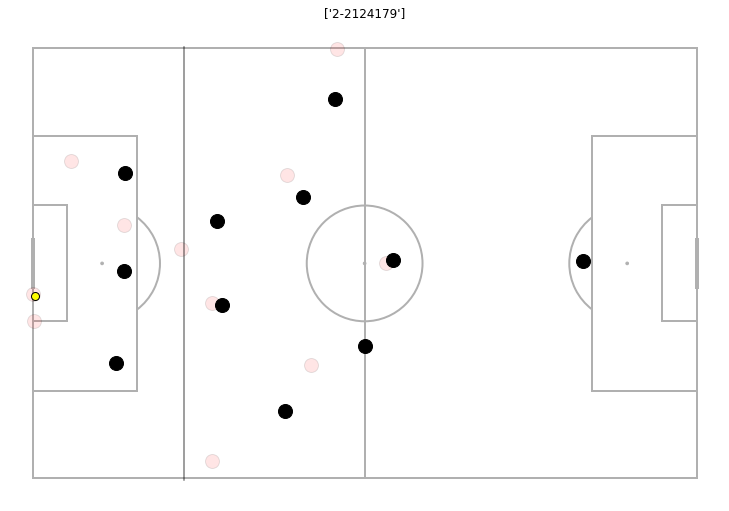

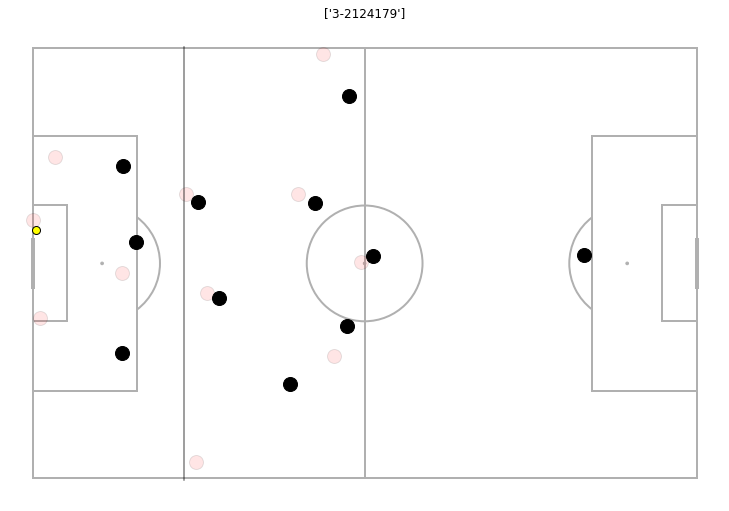

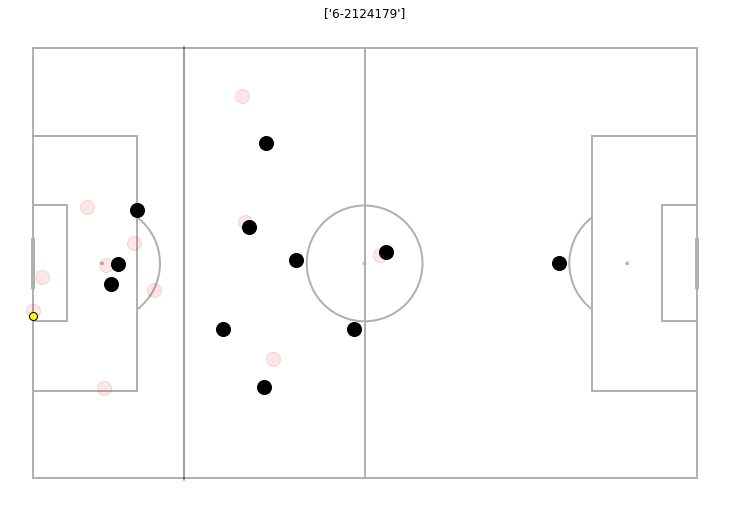

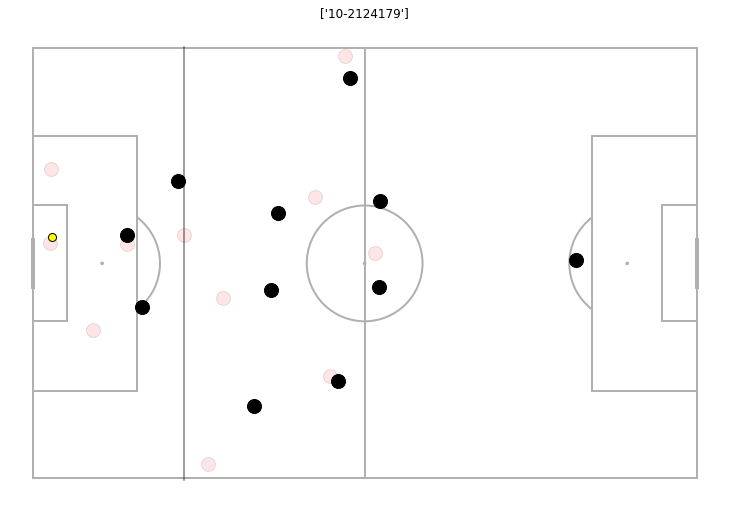

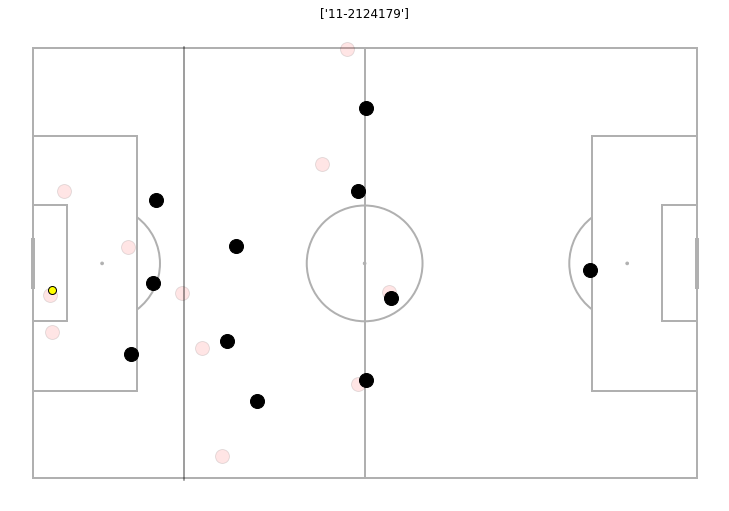

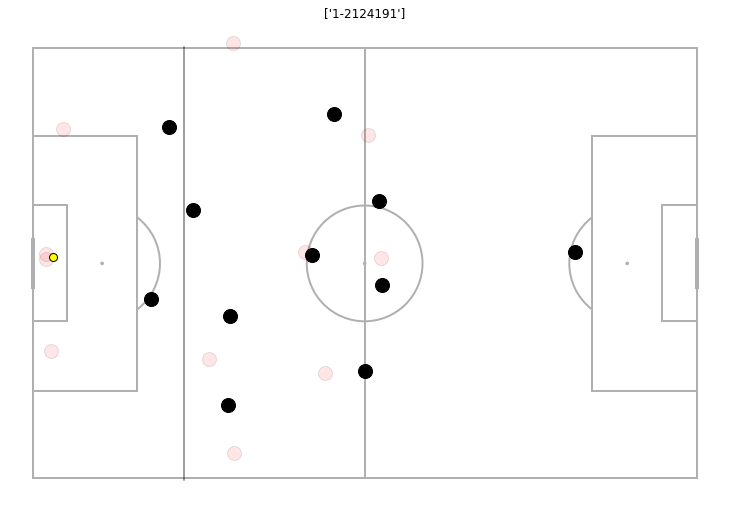

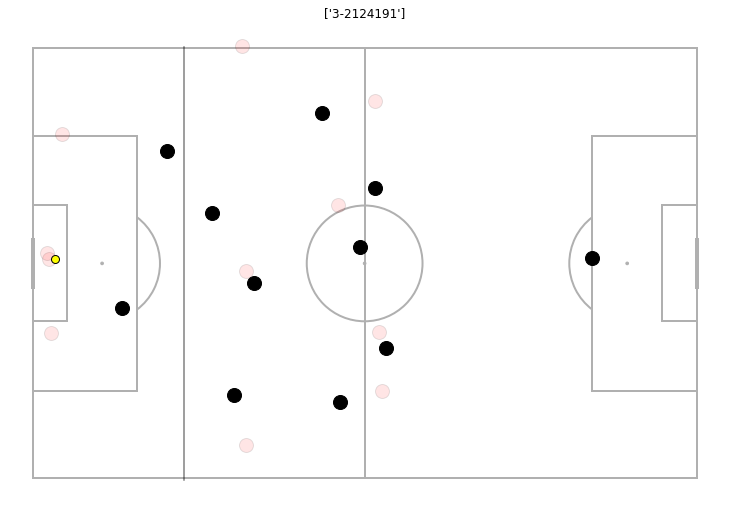

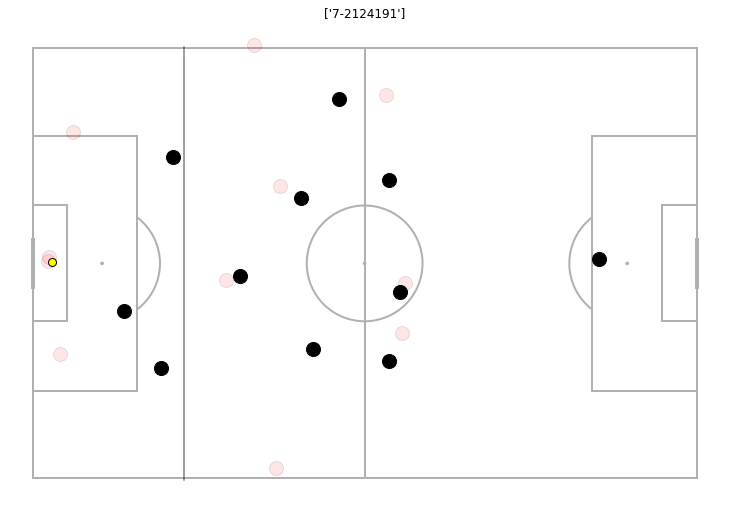

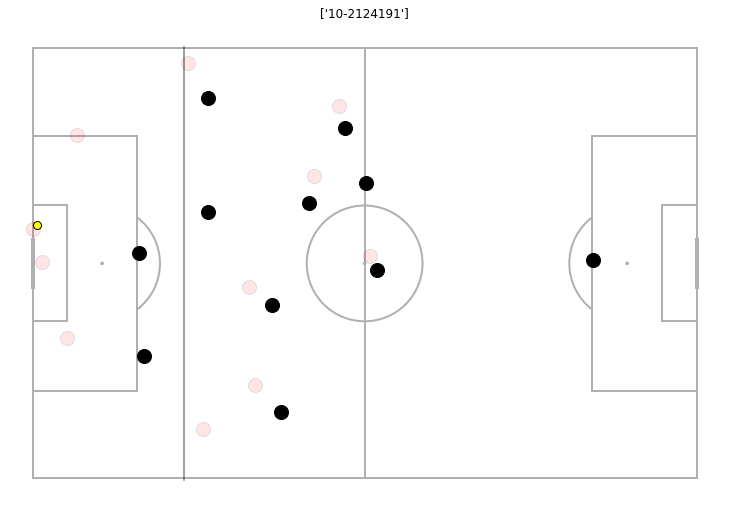

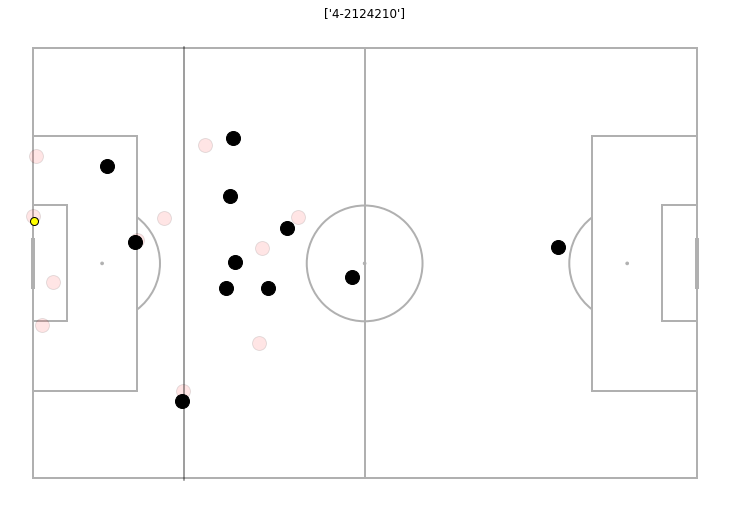

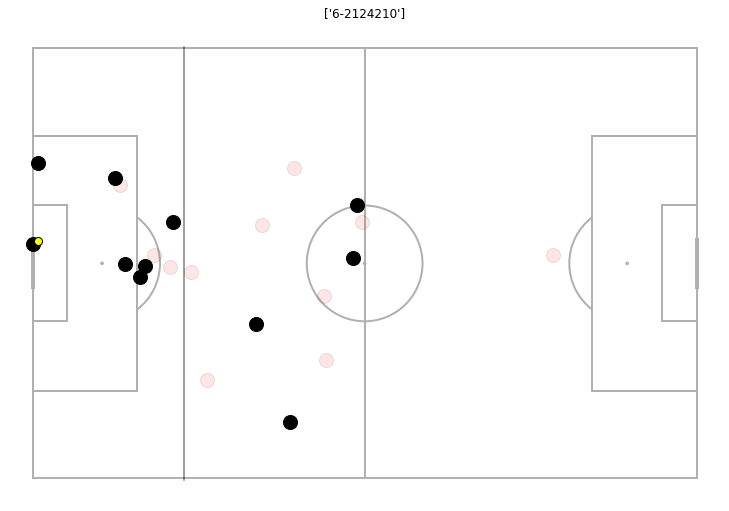

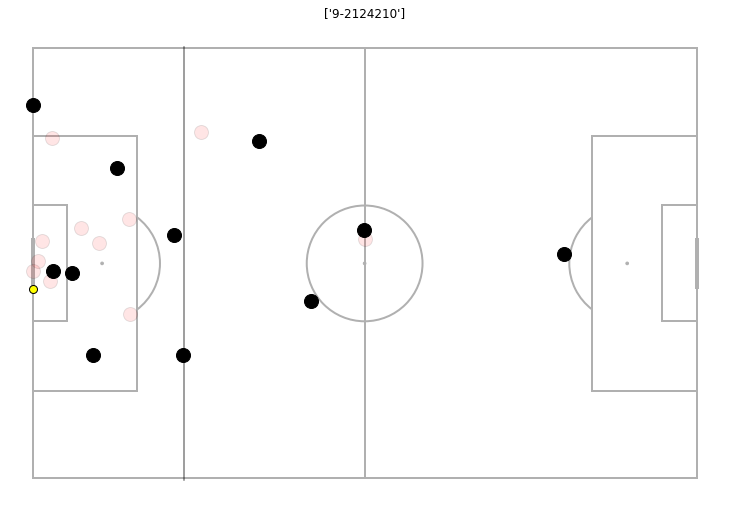

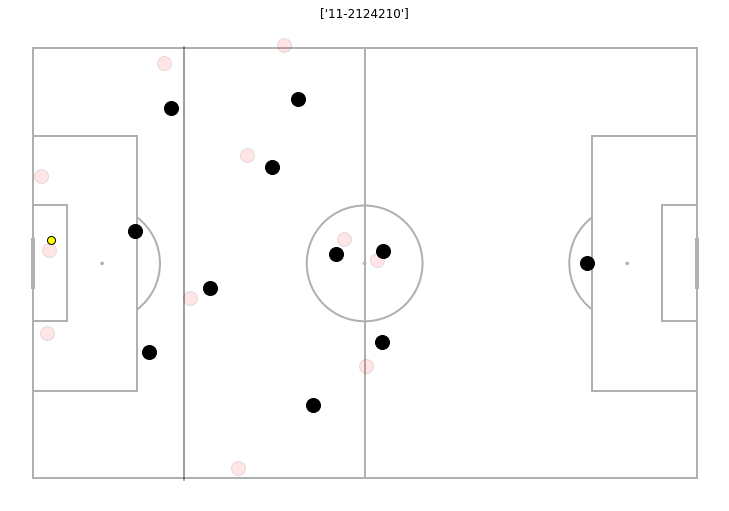

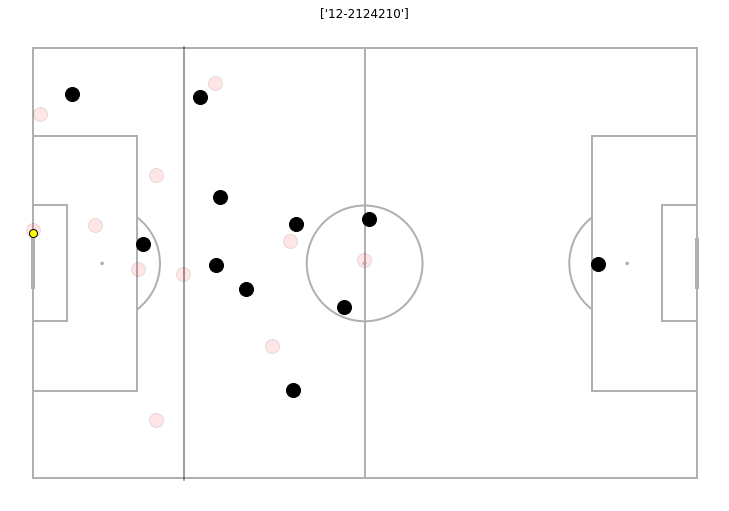

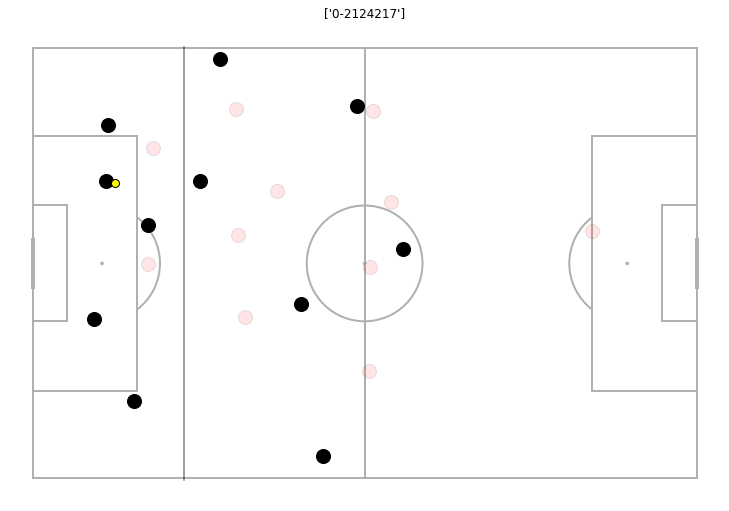

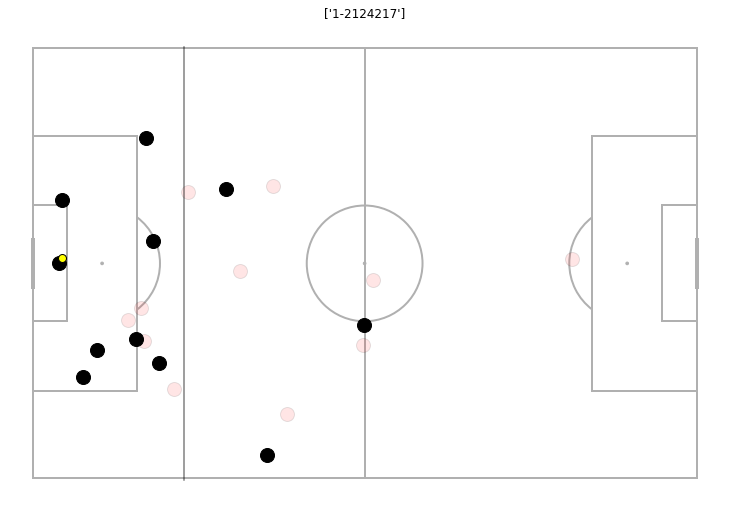

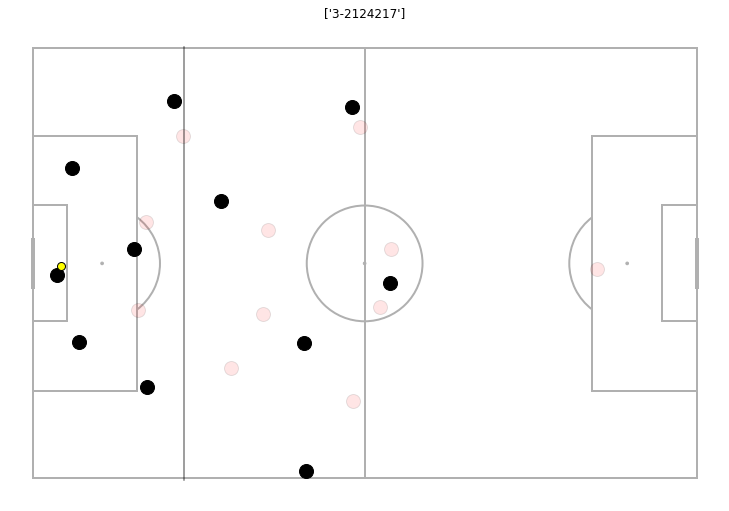

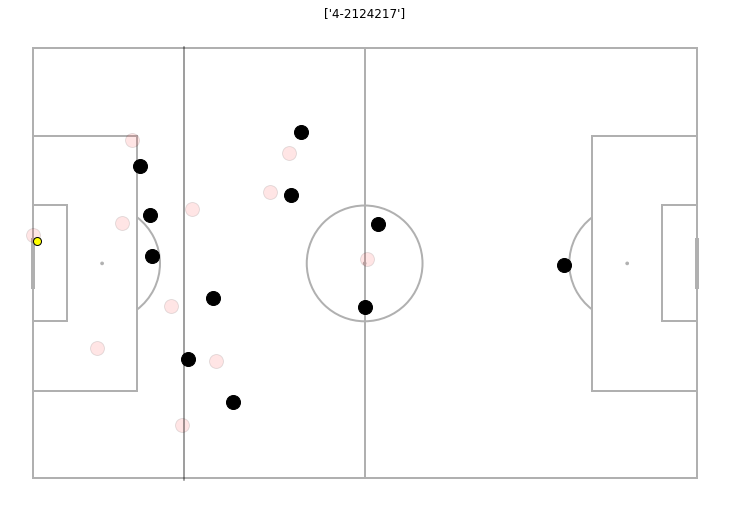

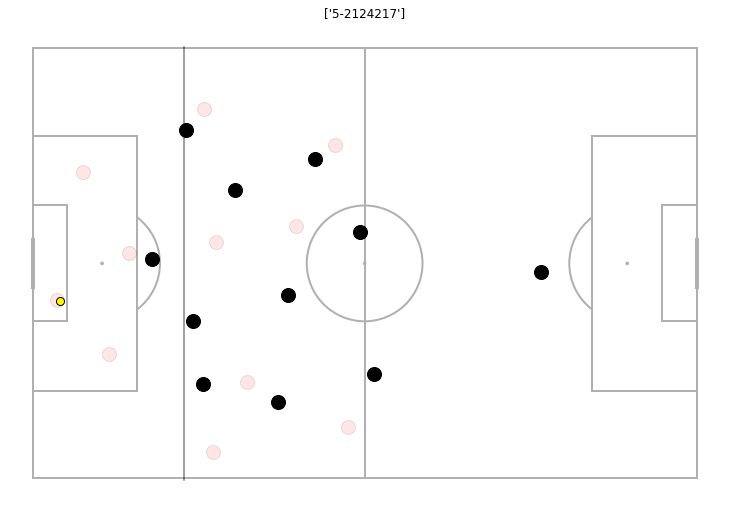

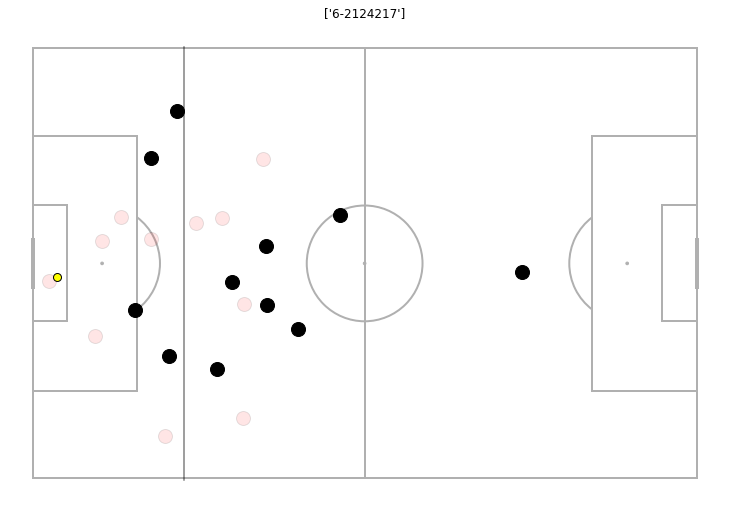

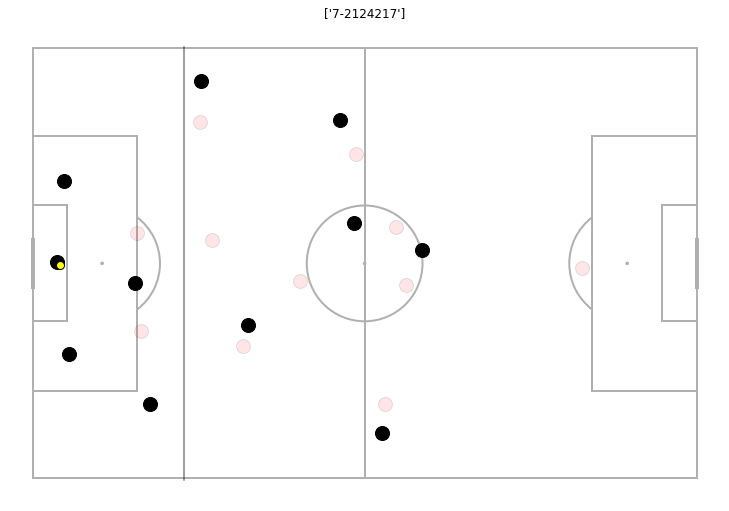

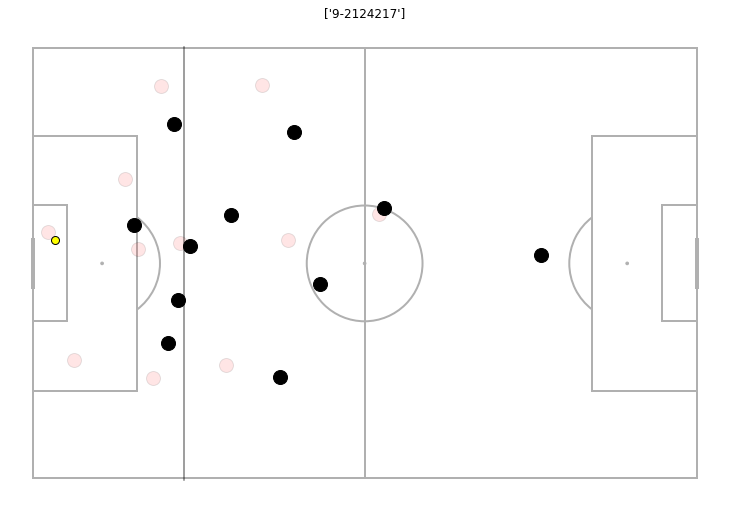

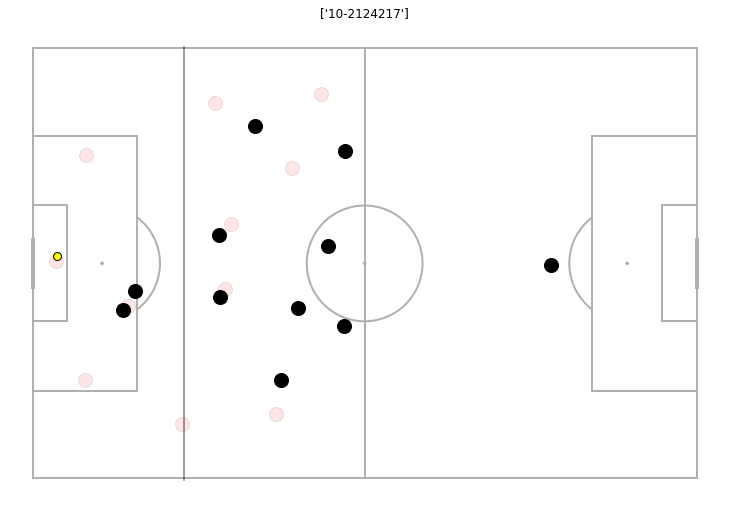

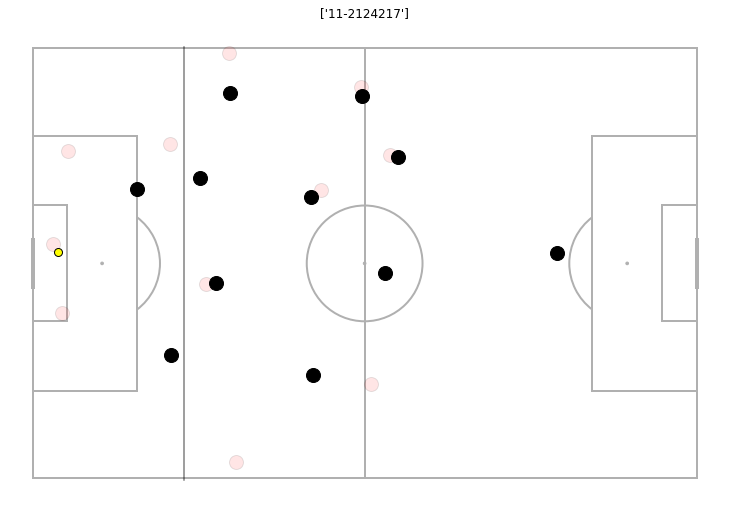

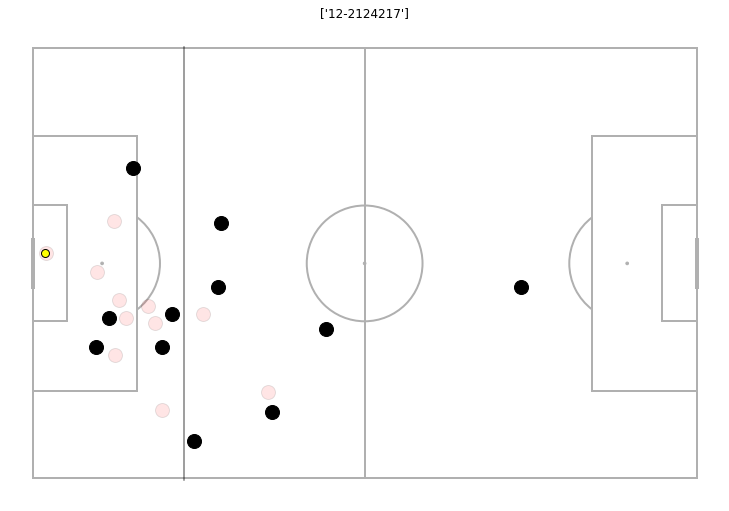

time: 25.1 s


In [101]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt

sequence_list1=list(A_subset.sequence.unique())
plt.rcParams['axes.facecolor'] = 'White'

for k in sequence_list1:


    ## test line break with back_line 
    #playa = A3.iloc[k]['player_id']
    #fra = A3.iloc[k]['sequence']

    frame___ = subset[(subset['sequence'] == k)].reset_index(drop=True)
    gk_sequence_summary_frames=list(frame___.frameIdx.unique())
    gk_sequence_summary_frames1=gk_sequence_summary_frames[0]
    
    frame___=frame___[frame___['frameIdx']==gk_sequence_summary_frames1].reset_index(drop=True)
    
    #### subsetting data for defensive team shape ###
    
    #frame___=frame___[(frame___['Possession_Result']=='Out_Possession') &
     #                (frame___['Team_Name']!='Ball')].reset_index(drop=True)
    
    #p_fra = frame___[frame___['player_id'] == playa].reset_index(drop=True)
    
    b_fra = frame___[frame___['Team_Name'] == 'Ball'].reset_index(drop=True)
    
    t_fra = frame___[(frame___['Team_Name'] == 'Atlanta United FC')& (frame___['Team_Name'] != 'Ball')].reset_index(drop=True)
    o_fra = frame___[(frame___['Team_Name'] != 'Atlanta United FC') & (frame___['Team_Name'] != 'Ball')].reset_index(drop=True)
    
    #o_fra=o_fra.sort_values(by='y1')

    # print(o_fra)
    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
        pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()


    #ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon
    

    ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=14,markerfacecolor='black', zorder=2,alpha=1) #red/maroon
    ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=14,markerfacecolor='red', zorder=1,alpha=0.1) #red/maroon
    ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=8,markerfacecolor='yellow', zorder=4) #red/maroon

    plt.axvline(x = 24, color = "black",alpha=0.5,ymin=0.05, ymax=0.95)
    #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 3000, color = "red")


    #plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) -1500, color = "red")
    #plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) - 3000, color = "red")
    
    plt.title(str(frame___.sequence.unique()))
    
    plt.savefig(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\High Press Starting Frames/'+'image'+str(k)+'.png')
    
    #plt.show()


    # print(p_fra)
    # print(o_fra)

In [ ]:
B3=df3[df3['sequence']=='3-2142717'].reset_index(drop=True)

In [118]:
###Import Results dataset
A1= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\A1.csv')
A2= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\A2.csv')
A3=A1.append(A2)
A_subset=A3[A3['sequence'].isin(success)].reset_index(drop=True)
A_subset

Unnamed: 0  frameIdx  First_Line  Second_Line  Third_Line  Fourth_Line  \
0            4     26739       14.37        27.00       45.42        56.00   
1            2     18933       14.22        19.27       39.58        54.38   
2           12    105432       14.04        21.17       43.49        58.12   
3            8     92673       20.70        28.31       41.78        51.78   
4            0      3253       16.55        27.83       39.62        55.55   
5            2     17877       14.49        17.74       47.06        59.26   
6           12    100883       17.63        18.83       39.72        58.18   
7            9    138900        6.41        26.42       33.03        54.12   
8            2     62267        2.63        16.50       46.32        56.01   
9            8    132796       11.03        17.43       38.47        55.36   
10           3     29346       14.41        27.43       40.98        54.60   

          Ball_Possession              Results                    OOP  \
0   ['Atlanta United FC']         ['Turnover']    ['Orlando City SC']   
1   ['Atlanta United FC']         ['Turnover']    ['Orlando City SC']   
2   ['Atlanta United FC']         ['Turnover']          ['FC Dallas']   
3   ['Atlanta United FC']         ['Turnover']    ['Chicago Fire FC']   
4          ['Opposition']  ['Success Zone 10']  ['Atlanta United FC']   
5   ['Atlanta United FC']         ['Turnover']     ['Inter Miami CF']   
6   ['Atlanta United FC']  ['Success Zone 10']     ['Inter Miami CF']   
7   ['Atlanta United FC']         ['Turnover']         ['Toronto FC']   
8   ['Atlanta United FC']         ['Turnover']   ['Columbus Crew SC']   
9   ['Atlanta United FC']         ['Turnover']   ['Columbus Crew SC']   
10  ['Atlanta United FC']  ['Success Zone 10']     ['Inter Miami CF']   

      sequence  ...     zone       GK_type Time Sequence_result frame_start  \
0    4-2124179  ...  Zone 10  Played-Short    2        Turnover       26739   
1    2-2124210  ...  Zone 10  Played-Short   11        Turnover       18933   
2   12-2142465  ...  Zone 11  Played-Short    6        Turnover      105432   
3   10-2142707  ...   Zone 6  Played-Short   14  Success-Zone10       92673   
4    0-2142717  ...   Zone 4  Played-Short   25  Success-Zone10        3253   
5    2-2142982  ...  Zone 10  Played-Short   16        Turnover       17877   
6   13-2142982  ...  Zone 10  Played-Short   13  Success-Zone10      100883   
7   10-2142998  ...   Zone 5  Played-Short   12        Turnover      138900   
8    2-2143045  ...   Zone 6  Played-Short   29  Success-Zone10       62267   
9   11-2143045  ...   Zone 5  Played-Short   19  Success-Zone10      132796   
10   3-2124175  ...  Zone 10  Played-Short   17  Success-Zone10       29346   

    frame_end  Block_type        Press_type  sequence_ID_count sec_diff  
0       26802  High-Block     High-Pressure                8.0     20.0  
1       19227  High-Block     High-Pressure                4.0     13.0  
2      105599  High-Block  Mid-Low Pressure                5.0     11.0  
3       93038  High-Block  Mid-Low Pressure                8.0     23.0  
4        3890  High-Block  Mid-Low Pressure                9.0     26.0  
5       18290  High-Block     High-Pressure                7.0     19.0  
6      101220  High-Block  Mid-Low Pressure                5.0     16.0  
7      139209  High-Block  Mid-Low Pressure                5.0     16.0  
8       63013  High-Block  Mid-Low Pressure               18.0     38.0  
9      133273  High-Block     High-Pressure               16.0     47.0  
10      29786  High-Block  Mid-Low Pressure                7.0     26.0  

[11 rows x 23 columns]

time: 181 ms


#### Reading the Data Frame again using H5 files ####

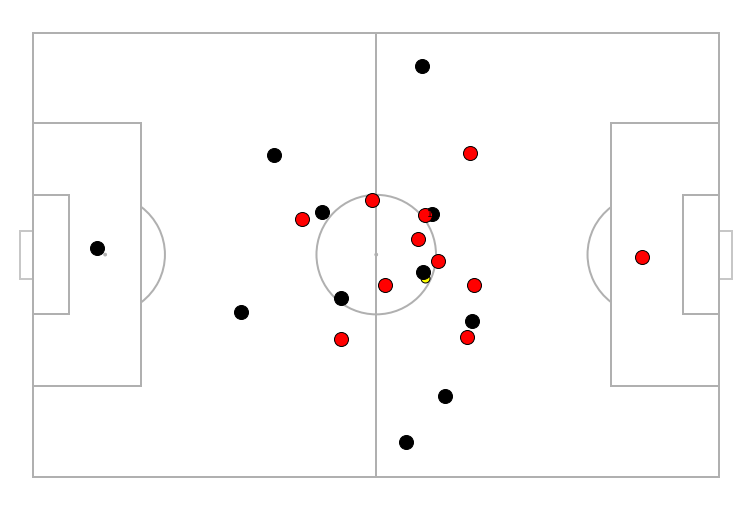

time: 1min 19s


In [120]:
from IPython.display import HTML
from matplotlib import animation
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt

B3=subset[subset['sequence']=='0-2142717'].reset_index(drop=True)

start=3253

end=3890

flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)

def animate_shot(starting_frame, ending_frame,Eve_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    #%matplotlib widget
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))


    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=70,stripe=False,goal_type='box', axis=False, label=False)
    fig, ax = pitch.draw()
    

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='black',alpha=1)
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)


    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        #ax.set_title(str(frames_to_animate[i]))
        
        
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = B3[B3['frameIdx'] == frames_to_animate[i]]
                
        #Direction=frame_['Direction'].unique()
        ball_ = frame_[frame_['Team_Name'] == 'Ball'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'Atlanta United FC') & (frame_['Team_Name'] != 'Ball')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'Atlanta United FC') & (frame_['Team_Name'] != 'Ball')].reset_index()[['number']]
                
        team1_ = frame_[frame_['Team_Name'] == 'Atlanta United FC'].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'Atlanta United FC'].reset_index()[['number']]

        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)

        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
             # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='black', fontsize=9, ax=ax)
                annotations.append(annot1)

            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1

        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='red', fontsize=9, ax=ax)
                annotations.append(annot2)

            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1


        #ax.margins(x=0, y=-0.25) 
        #plt.axvline(x = 24, color = "black",alpha=0.5,ymin=0.05, ymax=0.95)
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 msx`
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=False)
    return(anim)

#anim.save(r"C:\Users\Home\Documents\mwe.mov")
anim = animate_shot(start,end,1).to_html5_video()


HTML(anim)


In [117]:
##### subset for data for success sequences ####
success=['10-2142707','2-2143045','11-2143045','2-2124210','3-2124175','10-2142998','13-2142982','12-2142465','2-2142982','0-2142717','4-2124179']
subset=df3[df3['sequence'].isin(success)].reset_index(drop=True)

time: 3.98 s


In [ ]:
B3=B1[B1['sequence']=='0-2041250'].reset_index(drop=True)

In [ ]:
B1.head()

In [ ]:
#B=pd.read_csv(r'C:\Users\Home\Documents\A.csv')
track_seg11111.to_csv(r'C:\Users\Home\Documents\A2.csv')

In [18]:
#B3=result2[(result2['sequence'] == '9-2042207')].reset_index(drop=True)
mask = (Z10_Occupancy['frameIdx'] >= 77744) & (Z10_Occupancy['frameIdx'] <= 77755)
df1 = Z10_Occupancy.loc[mask]



time: 1.5 s


In [13]:
C1.to_csv(r'C:\Users\Home\Documents\7.csv')

time: 38 ms
